# Datasets (Sentiment)

## IMDB

- http://ai.stanford.edu/~amaas/data/sentiment/

&rarr; **BAD** - only single pos + neg review for each film

- https://www.imdb.com/interfaces/

&rarr; no review text!

## Yelp

- https://www.yelp.com/dataset/documentation/main

In [ ]:
! pip install jsonlines

[]

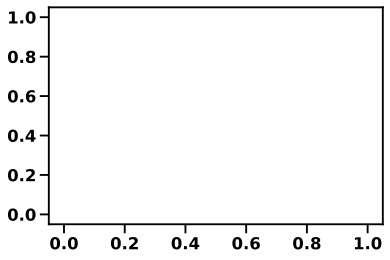

In [24]:
import os
import random
import pickle
from pathlib import Path

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats
from tqdm import tqdm

random.seed(42)
np.random.seed(42)

tqdm.pandas()

%matplotlib inline
plt.rcParams.update({"font.size": 25, "font.weight": "bold"})
# https://stackoverflow.com/questions/36622237/jupyter-notebook-inline-plots-as-svg
# set_matplotlib_formats("svg")  # glitches it
plt.plot()

In [2]:
# from utils_data import init_random
# init_random()

In [2]:
# download + scp to cuda + extract
data_yelp_path = Path("/home/ekoerner/same-side-classification/data/sentiment/yelp/")

In [4]:
fn_yelp_reviews = data_yelp_path / "review.json"

data = list()

with jsonlines.open(fn_yelp_reviews, "r") as fp:
    for n, entry in enumerate(tqdm(fp)):
        # print(entry)
        # break
        business_id = entry.pop("business_id")
        review_id = entry.pop("review_id")
        text = entry.pop("text", "")
        rating = entry.pop("stars", 0.0)
        data.append({"id": business_id, "rid": review_id, "text": text, "rating": rating})
        # TESTING
        # if n > 10000:
        #     break
        
df = pd.DataFrame.from_dict(data)

6685900it [00:42, 157834.84it/s]


In [5]:
fn_yelp_topics = data_yelp_path / "business.json"

inv_bid_cats = dict()
inv_cat_bids = dict()
bids_not_cats = set()


# load lookup business -> categories
with jsonlines.open(fn_yelp_topics, "r") as fp:
    for n, entry in enumerate(tqdm(fp)):
        business_id = entry.pop("business_id")
        categories = entry.pop("categories")
        
        if not categories:
            bids_not_cats.add(business_id)
            continue
        
        inv_bid_cats[business_id] = categories

# reverse lookup: category -> businesses
for bid, cats in tqdm(inv_bid_cats.items()):
    for cat in cats:
        try:
            inv_cat_bids[cat].append(bid)
        except KeyError:
            inv_cat_bids[cat] = [bid]

192609it [00:01, 108683.48it/s]
100%|██████████| 192127/192127 [00:01<00:00, 173989.81it/s]


In [6]:
# Add goodness value
# TODO: maybe ignore with 3
df["goodness"] = df["rating"] > 3

#### Test / Playground

In [ ]:
# exceprt
df  # .count()

In [ ]:
# ratings info
df.describe()

In [ ]:
# how many reviews per business (id)
df.groupby("id").count()[["rating"]].describe()

In [ ]:
# def fn_goodness(row):
#     row["good"] = True if row["rating"].value >= 2.5 else False
#     return row

# try:
#     df = df.progress_apply(fn_goodness, axis=1)
# except AttributeError:
#     df = df.apply(fn_goodness)

# set good if more than 3 in rating
df["goodness"] = df["rating"] > 3

In [ ]:
df.groupby(["goodness", "id"]).count()

In [ ]:
# select only those that have more than N reviews
df.groupby(["id", "goodness"])[["id"]].count() > 3

In [ ]:
# select only those IDs that contain both pos + negative reviews
df.groupby(["id", "goodness"], as_index=False).count().groupby("id")[["id"]].count() == 2

In [ ]:
len(df), len(df[df["rating"] == 3])

In [7]:
df.groupby(["rating"], ).count()[["id"]]

,id
rating,
1.0,1002159
2.0,542394
3.0,739280
4.0,1468985
5.0,2933082


#### Filter reviews with at least N ratings

In [8]:
# min ratings per class (good|bad)
min_ratings = 5

In [9]:
# filter with at least N ratings per goodness
df_filter = df.groupby(["id", "goodness"])[["id"]].count() < min_ratings
df_filter = df_filter.rename(columns={"id": "filter"})
df_filter = df_filter[df_filter["filter"] == True]

# build a filter id list
df_filter_list = df_filter.reset_index()["id"].to_list()

# filter with list
df_filtered = df[~df.id.isin(df_filter_list)]

In [10]:
df = df_filtered

#### Filter only reviews with both good and bad rating

In [11]:
# build filter for ids that contain both positive and negative samples
df_filter = df.groupby(["id", "goodness"], as_index=False).count().groupby("id")[["id"]].count() == 2
df_filter = df_filter.rename(columns={"id": "filter"})
df_filter = df_filter[df_filter["filter"] == True]

# create list of IDs for which this is true
df_filter_list = df_filter.reset_index()["id"].to_list()

# filter with list
df_filtered = df[df.id.isin(df_filter_list)]

# df_filtered
# df_filtered.groupby(["id", "goodness"]).count()

In [12]:
df = df_filtered

#### Make pairs

##### Positive + negative same-sentiment pairs

In [13]:
num_pairs_per_class = 2
# N positive + N negative
# --> 2N pos+neg (not same-sentiment)

# TODO: randomness for positive ss / negative ss - sum is equal / or sum equal compared to not ss

In [14]:
pairs_good = list()
pairs_bad = list()

for id_, group in tqdm(df.groupby("id")):
    grouper = group.groupby("goodness")
    reviews_good = grouper.get_group(True)
    reviews_bad = grouper.get_group(False)

    # TESTING
    # print("id:", id_)
    # print("#good:", len(reviews_good))
    # print("#bad:", len(reviews_bad))
    # print(group)
    # break

    # make pairings -- good ss
    rg_idx = reviews_good.index.values
    # print("pos_idx:", rg_idx)
    rg_idx_sel = np.random.choice(rg_idx, 2 * num_pairs_per_class, replace=False)
    for id1, id2 in zip(rg_idx_sel[::2], rg_idx_sel[1::2]):
        # print("pair:", id1, id2)
        r1, r2 = df.loc[id1], df.loc[id2]
        pair = {
            "argument1": r1["text"], "argument2": r2["text"],
            "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
            "is_same_side": True, "is_good_side": True,
            "topic": inv_bid_cats.get(r1["id"], None)
        }
        # print(pair)
        pairs_good.append(pair)

    # make pairings -- bad ss
    rb_idx = reviews_bad.index.values
    # print("neg_idx:", rb_idx)
    rb_idx_sel = np.random.choice(rb_idx, 2 * num_pairs_per_class, replace=False)
    for id1, id2 in zip(rb_idx_sel[::2], rb_idx_sel[1::2]):
        r1, r2 = df.loc[id1], df.loc[id2]
        pair = {
            "argument1": r1["text"], "argument2": r2["text"],
            "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
            "is_same_side": True, "is_good_side": False,
            "topic": inv_bid_cats.get(r1["id"], None)
        }
        pairs_bad.append(pair)
        
    # break

In [15]:
print("#ss (pos)", len(pairs_good))
print("#ss (neg)", len(pairs_bad))

#ss (pos) 123166
#ss (neg) 123166


##### not same-sentiment pairs (combinations positive + negative)

In [16]:
#: number of negative same-sentiment samples same as positive same-sentiment samples
num_pairs_negative = 2 * num_pairs_per_class

#: whether for a single side (good or bad) there can be multiple occurrences of the same review
#: may need to check afterwared that not by chance same pairing happens ...
repeatable_on_side = False

In [17]:
pairs_not_ss = list()

for id_, group in tqdm(df.groupby("id")):
    grouper = group.groupby("goodness")
    reviews_good = grouper.get_group(True)
    reviews_bad = grouper.get_group(False)

    # find indices for reviews per business
    rg_idx = reviews_good.index.values
    rb_idx = reviews_bad.index.values

    # randomly select from each side
    rg_idx_sel = np.random.choice(rg_idx, num_pairs_negative, replace=repeatable_on_side)
    rb_idx_sel = np.random.choice(rb_idx, num_pairs_negative, replace=repeatable_on_side)
    
    # pair them together -- good-bad pairs
    for idg, idb in zip(rg_idx_sel[::2], rb_idx_sel[::2]):
        rg, rb = df.loc[idg], df.loc[idb]
        pair = {
            "argument1": rg["text"], "argument2": rb["text"],
            "argument1_id": f"""{rg["id"]}|{rg["rid"]}""", "argument2_id": f"""{rb["id"]}|{rb["rid"]}""",
            "is_same_side": False, "is_good_side": None,
            "topic": inv_bid_cats.get(rg["id"], None)
        }
        # print(pair)
        pairs_not_ss.append(pair)
    
    # bad-good pairs
    for idb, idg in zip(rb_idx_sel[1::2], rg_idx_sel[1::2]):
        rb, rg = df.loc[idb], df.loc[idg]
        pair = {
            "argument1": rb["text"], "argument2": rg["text"],
            "argument1_id": f"""{rb["id"]}|{rb["rid"]}""", "argument2_id": f"""{rg["id"]}|{rg["rid"]}""",
            "is_same_side": False, "is_good_side": None,
            "topic": inv_bid_cats.get(rb["id"], None)
        }
        # print(pair)
        pairs_not_ss.append(pair)

In [18]:
print("#nss", len(pairs_not_ss))

#nss 246332


##### dataframe for training etc.

In [19]:
pairs_all = pairs_good + pairs_bad + pairs_not_ss
print("#~ss", len(pairs_all))

#~ss 492664


In [20]:
# print(pairs_all[0]["argument1_id"])
np.random.shuffle(pairs_all)
# print(pairs_all[0]["argument1_id"])

In [21]:
df_traindev = pd.DataFrame.from_dict(pairs_all)

In [22]:
fn_yelp_df = data_yelp_path / "df_traindev.p"

with open(fn_yelp_df, "wb") as fp:
    pickle.dump(df_traindev, fp, protocol=pickle.HIGHEST_PROTOCOL)

---

#### Reloading for training

In [3]:
data_yelp_path = Path("/home/ekoerner/same-side-classification/data/sentiment/yelp/")
fn_yelp_df = data_yelp_path / "df_traindev.p"

with open(fn_yelp_df, "rb") as fp:
    all_df = pickle.load(fp)

In [4]:
def _add_dummy_tag(row):
    row["tag"] = "NA"
    return row

# all_df = all_df.progress_apply(_add_dummy_tag, axis=1)
all_df["tag"] = "NA"

100%|██████████| 492664/492664 [04:22<00:00, 1873.51it/s]


In [5]:
num = len(all_df)
ratio = 0.3
idx_ratio = int(num * (1.0 - ratio))
print(f"traindev: [0:{idx_ratio}], test: [{idx_ratio}:{num}], ratio: {ratio}")

traindev_df = all_df.iloc[:idx_ratio]
test_df = all_df.iloc[idx_ratio:]

traindev: [0:344864], test: [344864:492664], ratio: 0.3


In [ ]:
# len(traindev_df), len(test_df)

##### Default S3C training

https://gluon-nlp.mxnet.io/install.html

```bash
pip install --upgrade 'mxnet>=1.3.0'  
pip install gluonnlp  
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip  
unzip sentence_embedding.zip  
ln -s sentence_embedding/bert bert  
```

In [6]:
from mxboard import SummaryWriter

from utils_data import get_train_test_sets

from utils_gluon import setup_bert_epi128bce, setup_bert_epi512bce
from utils_gluon import setup_bert_pro128bce, setup_bert_pro512bce

from utils_gluon import transform_dataset
from utils_gluon import predict_out_to_ys

from utils_gluon import predict
from utils_gluon import train

# from utils_gluon import print_infos
# from utils_gluon import plot_train_stats

from utils_gluon import report_training_results
from utils_gluon import plot_confusion_matrix

In [7]:
from utils_data import Timer

from utils_data import configure_logging
configure_logging()

from utils_data import init_random
init_random()

In [8]:
X_train, X_dev, y_train, y_dev = get_train_test_sets(traindev_df, ratio=0.1)

In [9]:
with Timer("setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert_pro128bce(gpu=1)

Start on [setup BERT model] ...
Time for [setup BERT model]: 0:00:06.299883


In [10]:
with Timer("prepare training / validation data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)

Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:19.241126


In [11]:
run_name = "yelp_1_pro128BCE"
fn_run_path = Path(f"data/{run_name}")

! mkdir data/yelp_1_pro128BCE

In [12]:
num_epochs = 3
batch_size = 32

##### Training with TRAIN set

In [14]:
for epoch_id in range(num_epochs):
    with Timer(f"train model - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=batch_size, lr=5e-6, num_epochs=epoch_id + 1, sw=sw, checkpoint_dir=str(fn_run_path))
        plot_train_stats(stats)

    with Timer(f"evaluate - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
        print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)

    model.save_parameters(str(fn_run_path / "bert.model.params"))

  0%|          | 30/310377 [00:00<17:22, 297.59it/s]

Start on [train model - 0] ...
Start on [setup training] ...


  0%|          | 0/9704 [00:00<?, ?it/s]

Time for [setup training]: 0:13:34.815246
Start on [training] ...
Start on [epoch 0] ...


  0%|          | 1/9704 [00:00<2:32:42,  1.06it/s]2020-03-16 01:15:20,393 : INFO : successfully opened events file: data/yelp_1_pro128BCE/events.out.tfevents.1584317720.cuda
2020-03-16 01:15:20,410 : INFO : wrote 1 event to disk
2020-03-16 01:15:20,512 : INFO : wrote 1 event to disk
  5%|▌         | 500/9704 [06:19<1:58:22,  1.30it/s]

[Epoch 0 Batch 500/9704] loss=0.6236, lr=0.0000050, acc=0.648 - time 0:06:19.515161


 10%|█         | 1000/9704 [12:40<1:52:24,  1.29it/s]

[Epoch 0 Batch 1000/9704] loss=0.5316, lr=0.0000050, acc=0.692 - time 0:06:21.485058


 15%|█▌        | 1500/9704 [19:02<1:46:32,  1.28it/s]

[Epoch 0 Batch 1500/9704] loss=0.4940, lr=0.0000050, acc=0.712 - time 0:06:21.379526


 21%|██        | 2000/9704 [25:23<1:40:13,  1.28it/s]

[Epoch 0 Batch 2000/9704] loss=0.4791, lr=0.0000050, acc=0.725 - time 0:06:21.454097


 26%|██▌       | 2500/9704 [31:44<1:31:11,  1.32it/s]

[Epoch 0 Batch 2500/9704] loss=0.4670, lr=0.0000050, acc=0.732 - time 0:06:21.085423


 31%|███       | 3000/9704 [38:06<1:26:43,  1.29it/s]

[Epoch 0 Batch 3000/9704] loss=0.4700, lr=0.0000050, acc=0.737 - time 0:06:22.037091


 36%|███▌      | 3500/9704 [44:28<1:19:16,  1.30it/s]

[Epoch 0 Batch 3500/9704] loss=0.4548, lr=0.0000050, acc=0.743 - time 0:06:21.126656


 36%|███▌      | 3501/9704 [44:28<1:17:02,  1.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 82%|████████▏ | 8000/9704 [1:41:05<21:18,  1.33it/s]

[Epoch 1 Batch 8000/9704] loss=0.3866, lr=0.0000050, acc=0.814 - time 0:06:19.603953


 88%|████████▊ | 8500/9704 [1:47:25<15:22,  1.31it/s]

[Epoch 1 Batch 8500/9704] loss=0.3892, lr=0.0000050, acc=0.814 - time 0:06:19.734777


 93%|█████████▎| 9000/9704 [1:53:45<09:00,  1.30it/s]

[Epoch 1 Batch 9000/9704] loss=0.3848, lr=0.0000050, acc=0.814 - time 0:06:20.015303


 98%|█████████▊| 9500/9704 [2:00:05<02:34,  1.32it/s]

[Epoch 1 Batch 9500/9704] loss=0.3769, lr=0.0000050, acc=0.814 - time 0:06:19.405313


100%|██████████| 9704/9704 [2:02:39<00:00,  1.30it/s]


Time for [epoch 1]: 2:02:39.610529


  0%|          | 0/9704 [00:00<?, ?it/s]

Start on [epoch 2] ...


  5%|▌         | 500/9704 [06:18<1:53:10,  1.36it/s]

[Epoch 2 Batch 500/9704] loss=0.3512, lr=0.0000050, acc=0.836 - time 0:06:18.735440


 10%|█         | 1000/9704 [12:37<1:49:14,  1.33it/s]

[Epoch 2 Batch 1000/9704] loss=0.3515, lr=0.0000050, acc=0.835 - time 0:06:19.172657


 10%|█         | 1010/9704 [12:45<1:51:12,  1.30it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



##### Results with validation set (DEV set)

  0%|          | 0/1078 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 1078/1078 [04:29<00:00,  4.55it/s]


Time for [prediction]: 0:04:29.455935
Confusion Matrix:
[[14101  3264]
 [ 3212 13910]]

CM: [14101  3264  3212 13910] 
[tn, fp, fn, tp]
  accuracy: 0.812
 precision: 0.812
    recall: 0.812
  f1-score: 0.812

Accuracy:  0.812 

Report for [BERTClassifier - yelp_1_pro128BCE]:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     17365
           1       0.81      0.81      0.81     17122

    accuracy                           0.81     34487
   macro avg       0.81      0.81      0.81     34487
weighted avg       0.81      0.81      0.81     34487



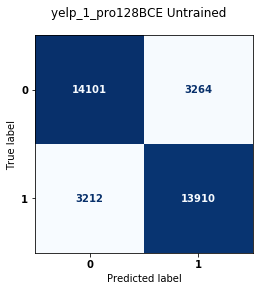

Evaluate trained model for each epoch ...
Load data/yelp_1_pro128BCE/bert.model.checkpoint0.params ...


  0%|          | 0/1078 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 1078/1078 [04:30<00:00,  4.24it/s]


Time for [prediction]: 0:04:30.814807
Confusion Matrix:
[[13496  3869]
 [ 3024 14098]]

CM: [13496  3869  3024 14098] 
[tn, fp, fn, tp]
  accuracy: 0.800
 precision: 0.801
    recall: 0.800
  f1-score: 0.800

Accuracy:  0.8 

Report for [BERTClassifier - yelp_1_pro128BCE]:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80     17365
           1       0.78      0.82      0.80     17122

    accuracy                           0.80     34487
   macro avg       0.80      0.80      0.80     34487
weighted avg       0.80      0.80      0.80     34487



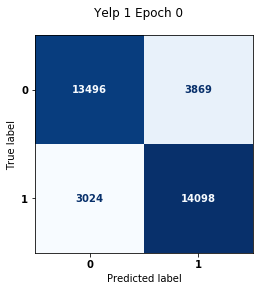

Load data/yelp_1_pro128BCE/bert.model.checkpoint1.params ...


  0%|          | 0/1078 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 1078/1078 [04:30<00:00,  4.21it/s]


Time for [prediction]: 0:04:30.831155
Confusion Matrix:
[[13757  3608]
 [ 2933 14189]]

CM: [13757  3608  2933 14189] 
[tn, fp, fn, tp]
  accuracy: 0.810
 precision: 0.811
    recall: 0.810
  f1-score: 0.810

Accuracy:  0.81 

Report for [BERTClassifier - yelp_1_pro128BCE]:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81     17365
           1       0.80      0.83      0.81     17122

    accuracy                           0.81     34487
   macro avg       0.81      0.81      0.81     34487
weighted avg       0.81      0.81      0.81     34487



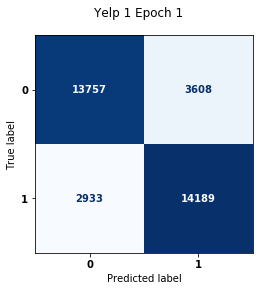

Load data/yelp_1_pro128BCE/bert.model.checkpoint2.params ...


  0%|          | 0/1078 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 1078/1078 [04:33<00:00,  4.18it/s]


Time for [prediction]: 0:04:33.773247
Confusion Matrix:
[[14101  3264]
 [ 3212 13910]]

CM: [14101  3264  3212 13910] 
[tn, fp, fn, tp]
  accuracy: 0.812
 precision: 0.812
    recall: 0.812
  f1-score: 0.812

Accuracy:  0.812 

Report for [BERTClassifier - yelp_1_pro128BCE]:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     17365
           1       0.81      0.81      0.81     17122

    accuracy                           0.81     34487
   macro avg       0.81      0.81      0.81     34487
weighted avg       0.81      0.81      0.81     34487



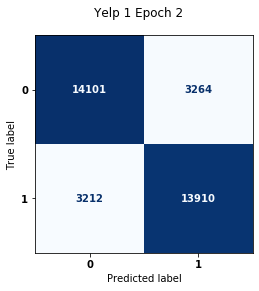

In [16]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
with open(fn_run_path / "eval_untrained.p", "wb") as fp:
    pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} Untrained", values_format="d", cmap="Blues", include_colorbar=False)
plt.show()

print("Evaluate trained model for each epoch ...")
for epoch_id in range(num_epochs):
    fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    with open(fn_run_path / f"eval_epoch{epoch_id}.p", "wb") as fp:
        pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp 1 Epoch {epoch_id}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()

##### Validate with TEST set (usually hidden y_true)

In [19]:
from utils_data import names_columns_X, names_columns_y

X_test = test_df[names_columns_X]
y_test = test_df[names_columns_y]
data_test_raw, data_test = transform_dataset(X_test, y_test, transform)

In [ ]:
epoch_id = num_epochs - 1
model.load_parameters(str(fn_run_path / f"bert.model.checkpoint{epoch_id}.params"), ctx=ctx)

all_predictions, cum_loss = predict(model, data_test, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
print("Accuracy:", metric.get()[1])

y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=True)
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {num_epochs} Epochs", values_format="d", cmap="Blues", include_colorbar=False)
plt.show()

Accuracy: 0.8129431664411366
Confusion Matrix:
[[60399 13871]
 [13776 59754]]

CM: [60399 13871 13776 59754] 
[tn, fp, fn, tp]
  accuracy: 0.813
 precision: 0.813
    recall: 0.813
  f1-score: 0.813


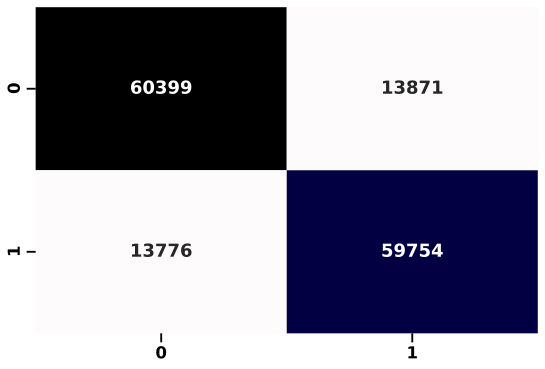


Accuracy:  0.813 

Report for [BERTClassifier - yelp_1_pro128BCE]:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     74270
           1       0.81      0.81      0.81     73530

    accuracy                           0.81    147800
   macro avg       0.81      0.81      0.81    147800
weighted avg       0.81      0.81      0.81    147800



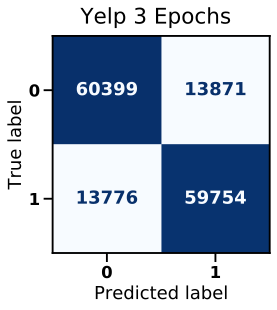

In [23]:
print("Accuracy:", metric.get()[1])

y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=True)
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {num_epochs} Epochs", values_format="d", cmap="Blues", include_colorbar=False)
plt.show()

##### Make layer until 6 static ...

In [31]:
print(model)

BERTClassifier(
  (bert): BERTModel(
    (encoder): BERTEncoder(
      (dropout_layer): Dropout(p = 0.1, axes=())
      (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
      (transformer_cells): HybridSequential(
        (0): BERTEncoderCell(
          (dropout_layer): Dropout(p = 0.1, axes=())
          (attention_cell): MultiHeadAttentionCell(
            (_base_cell): DotProductAttentionCell(
              (_dropout_layer): Dropout(p = 0.1, axes=())
            )
            (proj_query): Dense(768 -> 768, linear)
            (proj_key): Dense(768 -> 768, linear)
            (proj_value): Dense(768 -> 768, linear)
          )
          (proj): Dense(768 -> 768, linear)
          (ffn): BERTPositionwiseFFN(
            (ffn_1): Dense(768 -> 3072, linear)
            (activation): GELU()
            (ffn_2): Dense(3072 -> 768, linear)
            (dropout_layer): Dropout(p = 0.1, axes=())
            (layer_norm): BERTLayerNorm(eps=1e-12, axis

In [36]:
kwparams = model.collect_params()
keys = kwparams.keys()
lt6 = [
    k for k in keys
    if k.startswith("bertencoder0_transformer") and int(k[24]) in (
        0, 1, 2, 3, 4, 5) and k[25] == "_"
]
lt6

['bertencoder0_transformer0_multiheadattentioncell0_query_weight',
 'bertencoder0_transformer0_multiheadattentioncell0_query_bias',
 'bertencoder0_transformer0_multiheadattentioncell0_key_weight',
 'bertencoder0_transformer0_multiheadattentioncell0_key_bias',
 'bertencoder0_transformer0_multiheadattentioncell0_value_weight',
 'bertencoder0_transformer0_multiheadattentioncell0_value_bias',
 'bertencoder0_transformer0_proj_weight',
 'bertencoder0_transformer0_proj_bias',
 'bertencoder0_transformer0_bertpositionwiseffn0_ffn_1_weight',
 'bertencoder0_transformer0_bertpositionwiseffn0_ffn_1_bias',
 'bertencoder0_transformer0_bertpositionwiseffn0_ffn_2_weight',
 'bertencoder0_transformer0_bertpositionwiseffn0_ffn_2_bias',
 'bertencoder0_transformer0_bertpositionwiseffn0_bertlayernorm0_gamma',
 'bertencoder0_transformer0_bertpositionwiseffn0_bertlayernorm0_beta',
 'bertencoder0_transformer0_bertlayernorm0_gamma',
 'bertencoder0_transformer0_bertlayernorm0_beta',
 'bertencoder0_transformer1_mu

In [37]:
# normal params
params = [
    p for p in model.collect_params().values() if p.grad_req != 'null'
]
params

[Parameter bertencoder0_position_weight (shape=(512, 768), dtype=<class 'numpy.float32'>),
 Parameter bertencoder0_bertlayernorm0_gamma (shape=(768,), dtype=<class 'numpy.float32'>),
 Parameter bertencoder0_bertlayernorm0_beta (shape=(768,), dtype=<class 'numpy.float32'>),
 Parameter bertencoder0_transformer0_multiheadattentioncell0_query_weight (shape=(768, 768), dtype=float32),
 Parameter bertencoder0_transformer0_multiheadattentioncell0_query_bias (shape=(768,), dtype=float32),
 Parameter bertencoder0_transformer0_multiheadattentioncell0_key_weight (shape=(768, 768), dtype=float32),
 Parameter bertencoder0_transformer0_multiheadattentioncell0_key_bias (shape=(768,), dtype=float32),
 Parameter bertencoder0_transformer0_multiheadattentioncell0_value_weight (shape=(768, 768), dtype=float32),
 Parameter bertencoder0_transformer0_multiheadattentioncell0_value_bias (shape=(768,), dtype=float32),
 Parameter bertencoder0_transformer0_proj_weight (shape=(768, 768), dtype=float32),
 Parameter

In [44]:
def get_layer_nr(name):
    # name = param.name
    
    if not name.startswith("bertencoder") or "transformer" not in name:
        return None
    
    name_layer = name.split("_")[1]
    num = int(name_layer[11:])
    return num


def is_first_n_layer(name, n):
    return get_layer_nr(name) not in set(range(n))


def is_last_n_layer(name, n, params_all):
    num_layers = max(n for n in (get_layer_nr(p) for p in params_all.keys()) if n is not None) + 1
    return get_layer_nr(name) not in set(range(num_layers - n, num_layers))

In [46]:
params[10].name
get_layer_nr(params[10])

params = [
    p for p in model.collect_params().values()
    if p.grad_req != 'null' and not is_first_n_layer(p.name, 6)
]
params

[Parameter bertencoder0_position_weight (shape=(512, 768), dtype=<class 'numpy.float32'>),
 Parameter bertencoder0_bertlayernorm0_gamma (shape=(768,), dtype=<class 'numpy.float32'>),
 Parameter bertencoder0_bertlayernorm0_beta (shape=(768,), dtype=<class 'numpy.float32'>),
 Parameter bertencoder0_transformer6_multiheadattentioncell0_query_weight (shape=(768, 768), dtype=float32),
 Parameter bertencoder0_transformer6_multiheadattentioncell0_query_bias (shape=(768,), dtype=float32),
 Parameter bertencoder0_transformer6_multiheadattentioncell0_key_weight (shape=(768, 768), dtype=float32),
 Parameter bertencoder0_transformer6_multiheadattentioncell0_key_bias (shape=(768,), dtype=float32),
 Parameter bertencoder0_transformer6_multiheadattentioncell0_value_weight (shape=(768, 768), dtype=float32),
 Parameter bertencoder0_transformer6_multiheadattentioncell0_value_bias (shape=(768,), dtype=float32),
 Parameter bertencoder0_transformer6_proj_weight (shape=(768, 768), dtype=float32),
 Parameter

In [ ]:
# TODO: in trainer remove layer params that we do not want trained
# https://mxnet.incubator.apache.org/api/python/docs/_modules/mxnet/gluon/parameter.html#ParameterDict.zero_grad
# https://beta.mxnet.io/_modules/mxnet/gluon/block.html#Block.collect_params
# 
# ret = ParameterDict(self._params.prefix)
# ret.update({name:value for name, value in self.params.items() if pattern.match(name)})
# 
from mxnet.gluon.parameter import ParameterDict
params_all = model.collect_params()
params_sub = ParameterDict(params_all.prefix)
params_sub.update({name: value for name, value in params_all.items() if get_layer_nr(name) not in set(range(6))})

## Amazon

- https://nijianmo.github.io/amazon/index.html#subsets
- https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV#scrollTo=LgWrDtZ94w89

In [ ]:
from pathlib import Path
data_amazon_path = Path("/home/ekoerner/same-side-classification/data/sentiment/amazon/")

In [ ]:
# example from colab notebook

import pandas as pd
from tqdm import tqdm

In [ ]:
fn_amazon_auto_reviews = data_amazon_path / "Automotive_5.json"

data = list()
with jsonlines.open(fn_amazon_auto_reviews, "r") as fp:
    pass